In [1]:
import sys
import os

STOCKA_BASE_DIR = '/home/zzy/projects/stocka'
sys.path.insert(0, STOCKA_BASE_DIR)

from quant_framework import DataHandler, LGBModel

import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns

from tqdm import tqdm
from typing import Dict, List, Tuple, Any
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
dataset_config = {
    "train": ('2015-04-07', '2021-12-31'),
    'valid': ('2022-01-04', '2023-12-29'),
    'test': ('2024-01-02', '2025-12-30')
}

# dataset_config = {
#     "train": ('2015-04-07', '2023-12-29'),
#     'valid': ('2024-01-02', '2025-06-30'),
#     'test': ('2025-07-01', '2025-12-30')
# }

factors = ['KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'HIGH0', 'LOW0', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60']

hs300_codes = ['000001', '000002', '000063', '000100', '000157', '000166', '000301', '000333', '000338', '000408', '000425', '000538', '000568', '000596', '000617', '000625', '000630', '000651', '000661', '000708', '000725', '000768', '000776', '000786', '000792', '000807', '000858', '000876', '000895', '000938', '000963', '000975', '000977', '000983', '000999', '001391', '001965', '001979', '002001', '002027', '002028', '002049', '002050', '002074', '002142', '002179', '002230', '002236', '002241', '002252', '002304', '002311', '002352', '002371', '002384', '002415', '002422', '002459', '002460', '002463', '002466', '002475', '002493', '002594', '002600', '002601', '002625', '002648', '002709', '002714', '002736', '002916', '002920', '002938', '003816', '300014', '300015', '300033', '300059', '300122', '300124', '300251', '300274', '300308', '300316', '300347', '300394', '300408', '300413', '300418', '300433', '300442', '300476', '300498', '300502', '300628', '300661', '300750', '300759', '300760', '300782', '300803', '300832', '300866', '300896', '300979', '300999', '301236', '301269', '302132', '600000', '600009', '600010', '600011', '600015', '600016', '600018', '600019', '600023', '600025', '600026', '600027', '600028', '600029', '600030', '600031', '600036', '600039', '600048', '600050', '600061', '600066', '600085', '600089', '600104', '600111', '600115', '600150', '600160', '600161', '600176', '600183', '600188', '600196', '600219', '600233', '600276', '600309', '600346', '600362', '600372', '600377', '600406', '600415', '600426', '600436', '600438', '600460', '600482', '600489', '600515', '600519', '600522', '600547', '600570', '600584', '600585', '600588', '600600', '600660', '600674', '600690', '600741', '600760', '600795', '600803', '600809', '600845', '600875', '600886', '600887', '600893', '600900', '600905', '600918', '600919', '600926', '600930', '600938', '600941', '600958', '600989', '600999', '601006', '601009', '601012', '601018', '601021', '601058', '601059', '601066', '601077', '601088', '601100', '601111', '601117', '601127', '601136', '601138', '601166', '601169', '601186', '601211', '601225', '601229', '601236', '601238', '601288', '601298', '601318', '601319', '601328', '601336', '601360', '601377', '601390', '601398', '601456', '601600', '601601', '601607', '601618', '601628', '601633', '601658', '601668', '601669', '601688', '601689', '601698', '601728', '601766', '601788', '601800', '601808', '601816', '601818', '601825', '601838', '601857', '601868', '601872', '601877', '601878', '601881', '601888', '601898', '601899', '601901', '601916', '601919', '601939', '601985', '601988', '601995', '601998', '603019', '603195', '603259', '603260', '603288', '603296', '603369', '603392', '603501', '603799', '603893', '603986', '603993', '605117', '605499', '688008', '688009', '688012', '688036', '688041', '688047', '688082', '688111', '688126', '688169', '688187', '688223', '688256', '688271', '688303', '688396', '688472', '688506', '688981']

In [3]:
# import akshare as ak

# # 获取沪深300成分股列表
# df = ak.index_stock_cons_csindex(symbol="000300")
# # 股票代码列通常是'成分券代码'，转换为字符串列表格式
# hs300_codes = [code for code in df['成分券代码'].astype(str).str.zfill(6)]

# print(f"共获取 {len(hs300_codes)} 只股票")
# print(hs300_codes)  # 显示前10只

In [4]:
class CSZScoreNorm:
    """Cross Sectional ZScore Normalization"""

    def __init__(self, fields_group=None, method="zscore"):
        if method == "zscore":
            self.zscore_func = self.zscore
        elif method == "robust":
            self.zscore_func = self.robust_zscore

    def __call__(self, df):
        # 按 datetime 分组，对每组（每天）进行 zscore
        cols = factors + ['LABEL0']
        df[cols] = df[cols].groupby("date", group_keys=False).apply(self.zscore_func)
        return df
    
    def zscore(self, x):
        return (x - x.mean()) / x.std()
    
class ZScoreNorm:
    def __init__(self, segment='train', mean_train=None, mean_std=None):
        assert segment in ['train', 'valid', 'test']
        self.segment = segment
    
    def fit(self, df):
        # 只在 fit_start_time 到 fit_end_time 期间统计
        assert self.segment == 'train'
        self.mean_train = np.nanmean(df[factors].values, axis=0)  # 每个因子在训练期的均值
        self.std_train = np.nanstd(df[factors].values, axis=0)    # 每个因子在训练期的标准差
        
    def get_norm_params(self):
        assert self.segment == 'train'
        return self.mean_train, self.std_train
    
    def set_norm_params(self, mean_train, std_train):
        assert self.segment in ['valid', 'test']
        self.mean_train = mean_train
        self.std_train = std_train
    
    def __call__(self, df):
        if self.segment == 'train':
            self.fit(df)
        df[factors] = (df[factors] - self.mean_train) / self.std_train
        return df
    
class ProcessInf:
    """Process infinity"""
    
    def __call__(self, df):
        # 对每个时间点分别处理
        df[factors] = df[factors].groupby("date", group_keys=False).apply(self.process_inf_ultrafast)
        return df
    
    def process_inf_ultrafast(self, df):
        """超快速版本：利用groupby和transform的向量化操作"""
        # 将无穷值替换为NaN
        df[factors] = df[factors].replace([np.inf, -np.inf], np.nan)
        
        # 按日期计算每列的均值（自动忽略NaN）
        mean_by_date = df.groupby('date')[factors].transform('mean')
        
        # 只填充NaN值（原来的无穷值）
        df[factors] = df[factors].fillna(mean_by_date)
        
        return df
    
    def process_inf(self, df):
        for col in df.columns:
            # 用非无穷值的均值替换无穷值
            df[col] = df[col].replace([np.inf, -np.inf], df[col][~np.isinf(df[col])].mean())
        return df
    
class Fillna:
    def __init__(self, fill_value=0):
        self.fill_value = fill_value  # 默认填充为 0

    def __call__(self, df):
        return df.fillna(self.fill_value, inplace=True)
    
class ProcessLabel:
    def __init__(self, threshold=0.12):
        self.threshold=threshold
        
    def __call__(self, df):
        # 过滤极端值
        df = df.drop(df[df['LABEL0'].abs() > self.threshold].index)
        df = df.dropna(subset=['LABEL0'])
        
        # # 创建分类标签 LABEL1（7个类别）
        # # 类别定义：
        # # 0: < -0.075
        # # 1: -0.075 ~ -0.05
        # # 2: -0.05 ~ -0.025
        # # 3: -0.025 ~ 0.025
        # # 4: 0.025 ~ 0.05
        # # 5: 0.05 ~ 0.075
        # # 6: > 0.075
        
        # bins = [-np.inf, -0.075, -0.05, -0.025, 0.025, 0.05, 0.075, np.inf]
        # df['LABEL1'] = pd.cut(df['LABEL0'], bins=bins, labels=[0, 1, 2, 3, 4, 5, 6])
        # df['LABEL1'] = df['LABEL1'].astype(int)
        
        return df

In [5]:
class DataLoader:
    def __init__(self, config: Dict[str, Any], segment='train', stock_whitelist=None):
        self.config = config
        self.segment = segment
        assert segment in ['train', 'valid', 'test'], 'dataset part must be train, valid or test'
        if segment == 'train':
            self.mode = 'training'
        elif segment in ['valid', 'test']:
            self.mode = 'inference'
            
        self.data_handler = DataHandler(
            data_path=os.path.join(STOCKA_BASE_DIR, "data/factor/day/alpha158"),
            min_data_points=100,
            stock_whitelist=stock_whitelist,
            use_parquet=True,
            num_workers=32,
        )
        
        dataset_begin = self.config[self.segment][0]
        dataset_end = self.config[self.segment][1]
        self.data_handler.load_data(dataset_begin, dataset_end)
        
        self.cs_zscore_norm = CSZScoreNorm()
        self.zscore_norm = ZScoreNorm(segment)
        # self.process_inf = ProcessInf()
        # self.fill_na = Fillna()
        self.process_label = ProcessLabel()
        
    def get_label(self, df):
        df = df.copy()
        # 直接使用groupby的shift方法
        close_shift_1 = df.groupby(level=0)['close'].shift(-1)
        close_shift_2 = df.groupby(level=0)['close'].shift(-2)
        df['LABEL0'] = close_shift_2 / close_shift_1 - 1
        return df
    
    def get_zscore_norm_params(self):
        assert self.segment == 'train'
        return self.zscore_norm.get_norm_params()
        
    def load(self, mean_train=None, std_train=None):
        df = self.data_handler.get_all_data()
        # df = self.process_inf(df)
        # if self.part == 'train':
        #     df = self.zscore_norm(df)
        df = self.get_label(df)
        df = self.process_label(df)
        df = self.cs_zscore_norm(df)
        
        # if self.segment in ['valid', 'test']:
        #     self.zscore_norm.set_norm_params(mean_train, std_train)
        
        # df = self.zscore_norm(df)
        df.fillna(0, inplace=True)
        
        return df

In [6]:
# stock_whitelist=['000001', '000002', '000063', '000069', '000100', '000792']
# stock_whitelist = hs300_codes
stock_whitelist = None
train_data_loader = DataLoader(dataset_config, 'train', stock_whitelist)
valid_data_loader = DataLoader(dataset_config, 'valid', stock_whitelist)
test_data_loader = DataLoader(dataset_config, 'test', stock_whitelist)

开始加载数据，共找到 3047 个Parquet文件...
使用 32 个进程并行加载...


加载进度: 100%|██████████| 3047/3047 [00:05<00:00, 541.84it/s]


合并数据...
数据加载完成！
  - 股票数量: 2837
  - 日期范围: 2015-04-07 至 2021-12-31
  - 总数据点: 3857615
开始加载数据，共找到 3047 个Parquet文件...
使用 32 个进程并行加载...


加载进度: 100%|██████████| 3047/3047 [00:02<00:00, 1060.72it/s]


合并数据...
数据加载完成！
  - 股票数量: 2981
  - 日期范围: 2022-01-04 至 2023-12-29
  - 总数据点: 1420766
开始加载数据，共找到 3047 个Parquet文件...
使用 32 个进程并行加载...


加载进度: 100%|██████████| 3047/3047 [00:02<00:00, 1137.98it/s]


合并数据...
数据加载完成！
  - 股票数量: 3047
  - 日期范围: 2024-01-02 至 2025-12-30
  - 总数据点: 1463606


In [7]:
train_df = train_data_loader.load()
valid_df = valid_data_loader.load()
test_df = test_data_loader.load()

/home/zzy/miniconda3/envs/stocka/lib/python3.13/site-packages/pandas/core/nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/zzy/miniconda3/envs/stocka/lib/python3.13/site-packages/numpy/_core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zzy/miniconda3/envs/stocka/lib/python3.13/site-packages/pandas/core/nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/zzy/miniconda3/envs/stocka/lib/python3.13/site-packages/numpy/_core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zzy/miniconda3/envs/stocka/lib/python3.13/site-packages/pandas/core/nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [12]:
train_df[['close', 'LABEL0']]

close    LABEL0
code   date                         
000001 2015-04-07  1453.71  0.390692
       2015-04-08  1550.08  2.551992
       2015-04-09  1557.03 -0.442720
       2015-04-10  1713.30 -0.479302
       2015-04-13  1732.58  1.553175
...                    ...       ...
605507 2021-12-23    28.47  0.442610
       2021-12-24    28.36 -0.233662
       2021-12-27    28.82 -0.127169
       2021-12-28    28.76 -0.544646
       2021-12-29    28.65  0.964340

[3848153 rows x 2 columns]

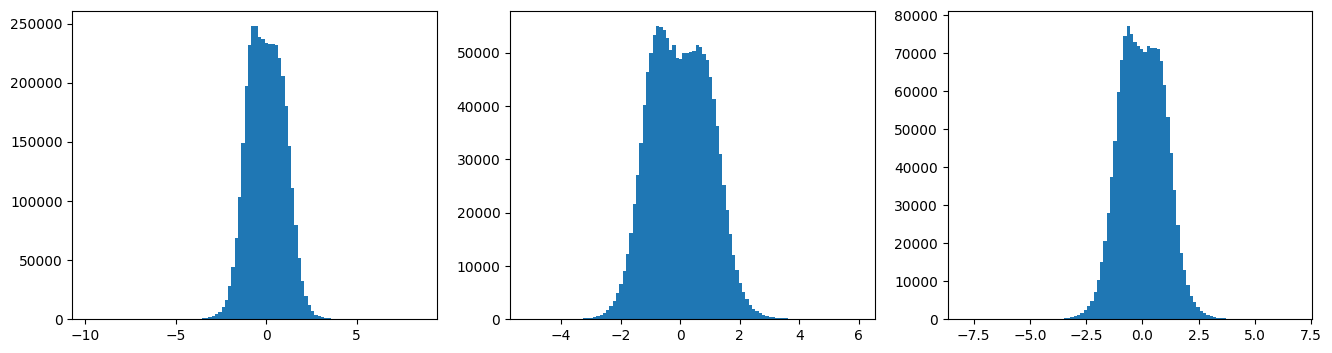

In [13]:
import matplotlib.pyplot as plt

factor_name = 'KMID2'
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(train_df[factor_name].values, bins=100)
ax[1].hist(valid_df[factor_name].values, bins=100)
ax[2].hist(test_df[factor_name].values, bins=100)
print('')

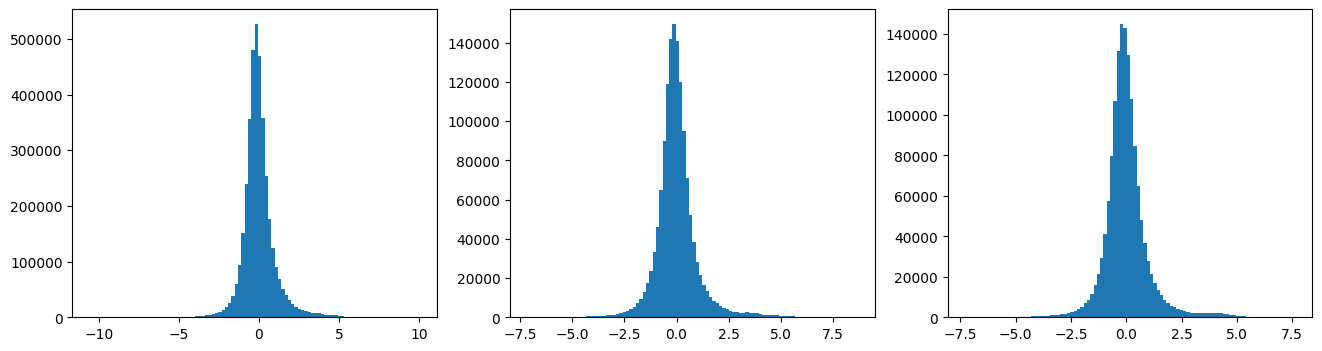

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(train_df['LABEL0'].values, bins=100)
ax[1].hist(valid_df['LABEL0'].values, bins=100)
ax[2].hist(test_df['LABEL0'].values, bins=100)
print('')

In [15]:
# class LGBModel:
#     """LightGBM Model for Regression"""

#     def __init__(self, loss="mse", early_stopping_rounds=50, num_boost_round=1000, **kwargs):
#         if loss not in {"mse", "binary"}:
#             raise NotImplementedError
#         self.params = {"objective": loss, "verbosity": -1}
#         self.params.update(kwargs)
#         self.early_stopping_rounds = early_stopping_rounds
#         self.num_boost_round = num_boost_round
#         self.model = None

#     def _prepare_data(self, df, reweighter=None) -> lgb.Dataset:
#         """
#         The motivation of current version is to make validation optional
#         - train segment is necessary;
#         """
#         x, y = df[factors], df["LABEL0"]
        
#         # Lightgbm need 1D array as its label
#         if y.values.ndim == 1:
#             pass
#         elif y.values.ndim == 2 and y.values.shape[1] == 1:
#             y = np.squeeze(y.values)
#         else:
#             raise ValueError("LightGBM doesn't support multi-label training")

#         if reweighter is None:
#             w = None
#         # elif isinstance(reweighter, Reweighter):
#         #     w = reweighter.reweight(df)
#         else:
#             raise ValueError("Unsupported reweighter type.")
        
#         return lgb.Dataset(x.values, label=y, weight=w, free_raw_data=False)

#     def fit(
#         self,
#         train_df: pd.DataFrame,
#         valid_df: pd.DataFrame,
#         num_boost_round=None,
#         early_stopping_rounds=None,
#         verbose_eval=20,
#         evals_result=None,
#         **kwargs,
#     ):
#         if evals_result is None:
#             evals_result = {}  # in case of unsafety of Python default values
#         train_dataset = self._prepare_data(train_df)
#         valid_dataset = self._prepare_data(valid_df)
        
#         early_stopping_callback = lgb.early_stopping(
#             self.early_stopping_rounds if early_stopping_rounds is None else early_stopping_rounds
#         )
#         # NOTE: if you encounter error here. Please upgrade your lightgbm
#         verbose_eval_callback = lgb.log_evaluation(period=verbose_eval)
#         evals_result_callback = lgb.record_evaluation(evals_result)
#         self.model = lgb.train(
#             self.params,
#             train_dataset,
#             num_boost_round=self.num_boost_round if num_boost_round is None else num_boost_round,
#             valid_sets=[train_dataset, valid_dataset],
#             valid_names=['train', 'valid'],
#             callbacks=[early_stopping_callback, verbose_eval_callback, evals_result_callback],
#             **kwargs,
#         )
#         # for k in ['train', 'valid']:
#         #     for key, val in evals_result[k].items():
#         #         name = f"{key}.{k}"
#         #         for epoch, m in enumerate(val):
#         #             # R.log_metrics(**{name.replace("@", "_"): m}, step=epoch)
#         #             print(f"epoch={epoch}, {name}.mse={m}")
#         #             # print(**{name.replace("@", "_"): m})

#     def predict(self, test_df: pd.DataFrame):
#         if self.model is None:
#             raise ValueError("model is not fitted yet!")
#         # x_test = dataset.prepare(segment, col_set="feature", data_key=DataHandlerLP.DK_I)
#         x_test = test_df[factors]
#         return pd.Series(self.model.predict(x_test.values), index=x_test.index)

In [16]:
model_config = {
    "loss": "mse",
    "colsample_bytree": 0.8879,
    "learning_rate": 0.0421,
    "subsample": 0.8789,
    "lambda_l1": 205.6999,
    "lambda_l2": 580.9768,
    "max_depth": 12,
    "num_leaves": 510,
    "num_threads": 32,
}

# model_config = {
#     "loss": "mse",
#     "colsample_bytree": 0.8879,
#     "learning_rate": 0.0421,
#     "subsample": 0.8789,
#     "lambda_l1": 205.6999,
#     "lambda_l2": 580.9768,
#     "max_depth": 8,
#     "num_leaves": 210,
#     "num_threads": 20,
# }


# model_config = {
#     "loss": "mse",
#     # "colsample_bytree": 0.8,
#     "learning_rate": 0.01,        # 降低学习率
#     "subsample": 0.8,
#     # "lambda_l1": 0.1,
#     # "lambda_l2": 0.1,
#     "max_depth": 6,
#     "num_leaves": 31,
#     "num_threads": 20,
#     "min_child_samples": 20,       # 增加最小叶子节点样本数
# }

model = LGBModel(early_stopping_rounds=100, factors=factors, **model_config)

In [18]:
training_info = model.fit(train_df, valid_df)

Training until validation scores don't improve for 100 rounds
[20]	train's l2: 0.975232	valid's l2: 0.995585
[40]	train's l2: 0.966128	valid's l2: 0.994494
[60]	train's l2: 0.961764	valid's l2: 0.99428
[80]	train's l2: 0.958883	valid's l2: 0.994241
[100]	train's l2: 0.956434	valid's l2: 0.994329
[120]	train's l2: 0.954154	valid's l2: 0.994398
[140]	train's l2: 0.952275	valid's l2: 0.994489
[160]	train's l2: 0.950488	valid's l2: 0.994576
Early stopping, best iteration is:
[72]	train's l2: 0.960039	valid's l2: 0.994236


In [20]:
from scipy import stats

def rearrange_series(s, value_name='value'):
    df = s.reset_index()
    df.columns = ['code', 'date', value_name]  # 重命名列
    return df.pivot(index='date', columns='code', values=value_name)

def calculate_ic(factor_values, returns):
    factor_values = factor_values[~np.isnan(factor_values)]
    returns = returns[~np.isnan(returns)]
    ic, _ = stats.pearsonr(factor_values, returns)
    return ic

def calculate_rank_ic(factor_values, returns):
    factor_values = factor_values[~np.isnan(factor_values)]
    returns = returns[~np.isnan(returns)]
    ic, _ = stats.spearmanr(factor_values, returns)
    return ic

In [22]:
predict = model.predict(test_df)
returns = test_df['close'].shift(-1) / test_df['close'] - 1
predict_df = rearrange_series(predict, 'predict')
returns_df = rearrange_series(returns, 'returns')

In [23]:
ic_list, rank_ic_list = [], []
for i in range(481):
    predict_i = predict_df[i:i + 1].values.flatten()
    returns_i = returns_df[i:i + 1].values.flatten()
    ic_i = calculate_ic(predict_i, returns_i)
    rank_ic_i = calculate_rank_ic(predict_i, returns_i)
    ic_list.append(float(ic_i))
    rank_ic_list.append(float(rank_ic_i))
    
ic_list = np.array(ic_list)
rank_ic_list = np.array(rank_ic_list)

In [24]:
ic_list.mean(), rank_ic_list.mean()

(np.float64(0.10558105405702313), np.float64(0.06825613490712142))

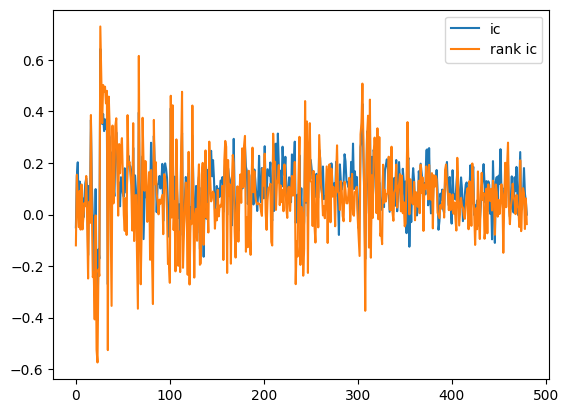

In [25]:
plt.plot(ic_list, label='ic')
plt.plot(rank_ic_list, label='rank ic')
plt.legend()

In [30]:
def plot_regression_scatter(df, segment='test'):
    predict = model.predict(df)
    mse = np.mean((predict.values - df['LABEL0'].values)**2)
    plt.scatter(df['LABEL0'].values, predict.values, alpha=0.2)
    plt.xlabel('truth')
    plt.ylabel('prediction')
    plt.title(f"{segment}_mse={mse}")

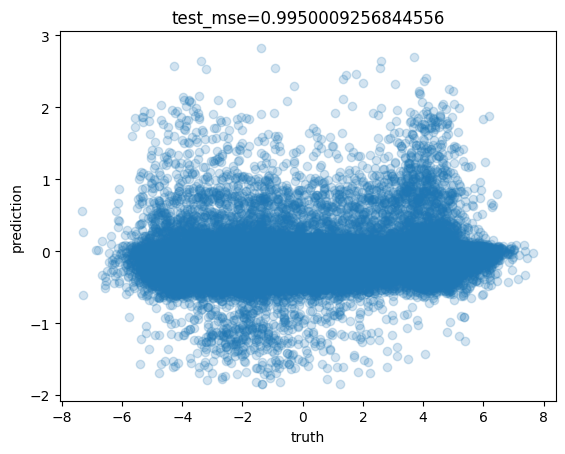

In [31]:
plot_regression_scatter(test_df, 'test')

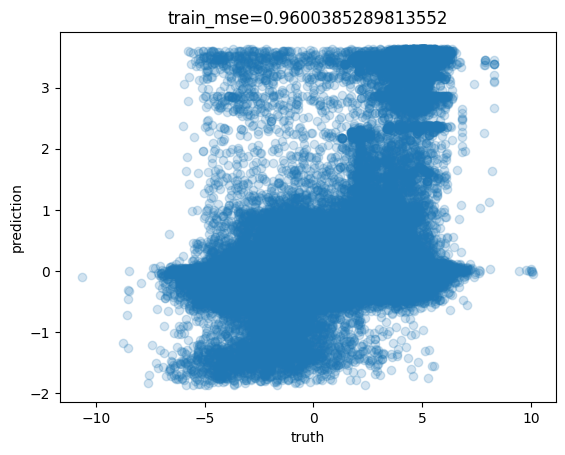

In [32]:
plot_regression_scatter(train_df, 'train')

In [33]:
model.save_model('lightgbm_model')

✓ 模型已保存到: lightgbm_model.pkl


In [34]:
model_load = LGBModel.load_model('lightgbm_model.pkl')

✓ 模型已从 lightgbm_model.pkl 加载
  - 训练轮数: 72


In [40]:
((model_load.predict(test_df).values - predict.values) ** 2).mean()

np.float64(0.0)